In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import imageio
from IPython.display import Image
from pathlib import Path
from glob import glob
import pandas as pd

In [10]:
def get_puzzle(numbers, grid_n=3):
    grid_n = 3
    max_num = grid_n * grid_n
    puzzle = np.zeros((grid_n, grid_n), np.uint8)
    for idx in range(max_num):
        puzzle[idx//grid_n, idx%grid_n] = numbers[idx]    
    return puzzle

def get_gt(grid_n=3):
    puzzle = get_puzzle([1,2,3,4,5,6,7,8,0], grid_n=3)
    return puzzle

def show(puzzle, label=''):
    plt.imshow(puzzle, cmap='Set1')
    plt.axis('off')
    if type(label) == list:
        label = ' '.join(label)
    plt.title(label)
    for (j,i),label in np.ndenumerate(puzzle):
        if label == 0:continue
        plt.text(i,j,label,ha='center',va='center', fontsize=20)
        
def get_counter_action(action):
    if action == 'R': return 'L'
    if action == 'L': return 'R'
    if action == 'U': return 'D'
    if action == 'D': return 'U'
        
def get_actions(puzzle):
    y, x = np.where(puzzle==0)

    # Right, Upper, Left, Down
    if y == 0 and x == 0:
        actions = ['R', 'D']
    if y == 1 and x == 0:
        actions = ['R', 'U', 'D']
    if y == 2 and x == 0:
        actions = ['R', 'U']
    if y == 0 and x == 1:
        actions = ['R', 'L', 'D']
    if y == 1 and x == 1:
        actions = ['R', 'U', 'L', 'D']
    if y == 2 and x == 1:
        actions = ['R', 'U', 'L']
    if y == 0 and x == 2:
        actions = ['L', 'D']
    if y == 1 and x == 2:
        actions = ['U', 'L', 'D']
    if y == 2 and x == 2:
        actions = ['U', 'L']
    return actions

def do_action(action, puzzle):
    y, x = np.where(puzzle==0)
    if action == 'R': puzzle[y, x], puzzle[y, x+1] = puzzle[y, x+1], 0
    if action == 'L': puzzle[y, x], puzzle[y, x-1] = puzzle[y, x-1], 0
    if action == 'U': puzzle[y, x], puzzle[y-1, x] = puzzle[y-1, x], 0
    if action == 'D': puzzle[y, x], puzzle[y+1, x] = puzzle[y+1, x], 0
    return puzzle
    
def city_block_loss(puzzle, puzzle_gt):
    error = 0
    for value in puzzle_st.ravel():
        y_pred, x_pred = np.where(puzzle==value)
        y_true, x_true = np.where(puzzle_gt==value)
        error += np.abs(y_pred - y_true)[0] + np.abs(x_pred - x_true)[0]
    return error

def write_log(log_file, idx, frontier):
    if idx == 0:
        mode = 'w'
    else:
        mode = 'a'
        
    print_str = f'Frontier {idx:03d}: '
    for elem in frontier:
        puzzle_rep = ''.join(''.join(map(str, elem.puzzle.ravel())))
        path = ''.join(elem.path)
        print_str += (f"{puzzle_rep} {path} {elem.loss};")
    with open(log_file, mode) as f:
        f.write(print_str+'\n')

def write_final_path(log_file, path):
    print_str = "Final Path: " + ''.join(path)+'\n'
    with open(log_file, 'a') as f:
        f.write(print_str)
    
class Candidate:
    def __init__(self, puzzle, path, loss):
        self.puzzle = puzzle
        self.path   = path
        self.loss   = loss
    def __str__(self):
        print_str = ' '.join(self.path) + f' loss: {self.loss}'
        show(self.puzzle, print_str)
        return ''
    
    def __repr__(self):
        return ' '.join(map(str,self.puzzle.ravel()))  

def sorted_key(elem):
    return elem.loss

def search(frontier, puzzle_gt, log_file, idx):
    # Select
    if len(frontier) == 0:
        print("Error! Empty Frontier")
        return -1, frontier
    curr_candidate = frontier.pop(0)
    # Test
    loss = city_block_loss(curr_candidate.puzzle, puzzle_gt)
    if loss == 0: # solution
        write_final_path(log_file, curr_candidate.path)
        show(curr_candidate.puzzle, curr_candidate.path + [f'Loss: {curr_candidate.loss}'])
        return 0, [curr_candidate] + frontier
    
    # Generate 
    actions = get_actions(curr_candidate.puzzle)
    # Insert 
    new_candidates = []
    for action in actions:
        if len(curr_candidate.path) and action == get_counter_action(curr_candidate.path[-1]):
            continue
        new_puzzle = do_action(action, curr_candidate.puzzle.copy())
        new_path   = curr_candidate.path + [action]
        # F        = G             + H
        new_loss   = len(new_path) + city_block_loss(new_puzzle, puzzle_gt)
        candidate  = Candidate(new_puzzle, new_path, new_loss)
        frontier.append(candidate)
        
    frontier = sorted(frontier, key=sorted_key, reverse=False)
    write_log(log_file, idx, frontier)
    return 1, frontier

def solver(puzzle_st, puzzle_gt, log_file, max_iter=5000):
    start_loss = city_block_loss(puzzle_st, puzzle_gt)
    frontier = [Candidate(puzzle_st, [], start_loss)]
    write_log(log_file, 0, frontier)
    
    for idx in range(max_iter):
        code, frontier = search(frontier, puzzle_gt, log_file, idx+1)

        if code == 0:
            print("Solution Founded!")
            break
    if code != 0:print("Solver Failed")
    return frontier
    

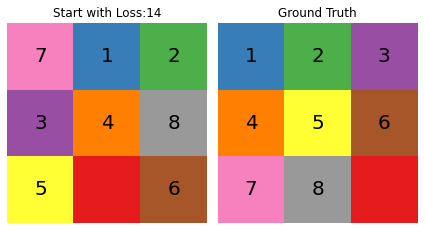

In [24]:
#start_arr  = [1,8,2,0,4,3,7,6,5]
#start_arr = [3,2,7,8,0,4,1,5,6]
start_arr = [7,1,2,3,4,8,5,0,6]

to_arr    = ''.join(map(str,start_arr))

save_path = f"extra/{to_arr}"
log_file  = save_path + f"/log.txt"
Path(save_path).mkdir(exist_ok=True, parents=True)

puzzle_st = get_puzzle(start_arr)        
puzzle_gt = get_gt()
loss_st   = city_block_loss(puzzle_st, puzzle_gt)

plt.subplot(121)
show(puzzle_st, f"Start with Loss:{loss_st}")
plt.subplot(122)
show(puzzle_gt, "Ground Truth")
plt.tight_layout()
plt.savefig(f"extra/{to_arr}/start-gt.png")

Solution Founded!


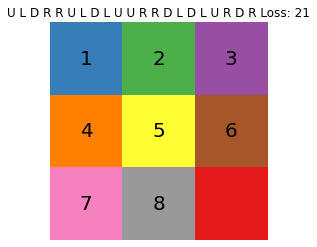

In [25]:
frontier = solver(puzzle_st.copy(), puzzle_gt,  log_file)

In [26]:
puzzle_view, keys_arr = [], []

draw_puzzle = puzzle_st.copy()
plt.ioff()
show(draw_puzzle, '')    
plt.savefig(save_path+f'/{0:03d}.jpg')
plt.close()

for idx, key in enumerate(frontier[0].path):
    keys_arr.append(key)
    plt.figure()
    show(do_action(key, draw_puzzle), keys_arr)    
    plt.savefig(save_path+f'/{idx+1:03d}.jpg')
    plt.close()


In [27]:
puzzle_view = [cv2.imread(url)[..., ::-1] for url in sorted(glob(save_path+'/*.jpg'))]

In [28]:
save_path_gif = fr'extra/{to_arr}/summary.gif'
imageio.mimsave(save_path_gif, puzzle_view, fps=2)


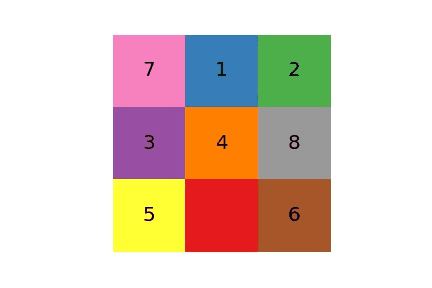

In [29]:
with open(save_path_gif, 'rb') as f:
    display(Image(data=f.read(), format='png'))
